# Projeto 2 - Ciência dos Dados - 2020.2 

### Previsão da demanda em lojas Walmart estadunidenses a fim de evitar o desperdício, maximizando o lucro nesses estabelecimentos

#### Equipe: Andressa Silva de Oliveira; Camila Buzin Ladeira; Luiz Ricardo Hardman; Matheus Kwon

## - Introdução -

##### Objetivo:
A previsão de dados é extremamente valiosa nas mais diversas áreas, sendo utilizada para otimizar processos e serviços variados. No contexto em questão, a previsão de vendas em lojas Walmart é fundamental para que haja um controle adequado do estoque de acordo com a demanda; a redução nas perdas leva à otimização dos lucros nesses estabelecimentos. Dessa forma, objetiva-se construir, ao longo deste arquivo, dois modelos de previsão.


##### Descrição da base de dados:

Pensando em como nos dias atuais a habilidade de prever futuras vendas de uma empresa é um fator importante para montar um business plan, analisamos então no nosso projeto uma base de dados das vendas semanais  do Walmart , onde poderíamos relacionar fatores internos ou externos ao comportamento dessas vendas. Utilizamos apenas uma base de dados que nos traziam informação de lojas, datas, temperatura, taxa de desemprego, momentos de feriado, etc..

Base de dados Walmart_Store_sales :

- **store**: representa a numeração da loja representada, 1-45;
- **data**: variável que apresenta dia, mês e ano do dado, respectivamente, representando a semana que as observações foram tomadas;
- **weeklysales** : variável que apresenta a receita de cada loja semanalmente (US\$) $\Rightarrow\$ variável de monitoramento;
- **holiday**: variável que representa se a data do dado é feriado ou não (yes/no);
- **temperature** : variável que apresenta a temperatura média da semana na região de  cada loja, em fahrenheit (°F);
- **fuel**: preço do galão de gasolina no dia do dado (US\$);
- **cpi** : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores.( Índice de preços no consumidor )  (US\$);
- **unemployment** : variável que representa a taxa de desemprego durante a semana, na região de cada loja, de zero a um.

## - Minerando Dados e Características do Dataset -

In [56]:
# Bibliotecas importadas:
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Código para reconhecimento do dataset:
filename = 'Walmart_Store_sales.xlsx'

if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo!')
else:
    print(f'Não encontrei o arquivo {filename} no diretório {os.getcwd()}')

Encontrei o arquivo Walmart_Store_sales.xlsx, tudo certo!


In [4]:
# Código para leitura do dataset:
data = pd.read_excel(filename)
data.head(5)

,"Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment"
0,"1,05-02-2010,1643690.9,0,42.31,2.572,211.09635..."
1,"1,12-02-2010,1641957.44,1,38.51,2.548,211.2421..."
2,"1,19-02-2010,1611968.17,0,39.93,2.514,211.2891..."
3,"1,26-02-2010,1409727.59,0,46.63,2.561,211.3196..."
4,"1,05-03-2010,1554806.68,0,46.5,2.625,211.35014..."


In [5]:
# Manipulação do dataset para fins do projeto

linhas = data['Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment']

dicio = {'store':[], 'date':[], 'weeklysales':[], 'holiday':[], 'temperature':[], 'fuel':[], 'cpi':[], 'unemployment':[]}

# Separação das colunas no dicionário, em forma de listas

for linha in linhas:
    results = linha.split(',')
    i = 0
    for key in dicio.keys():
        variable = results[i]
        if key != 'date' and key != 'holiday' and key != 'store':
            variable = float(results[i])
        dicio[key].append(variable)
        i += 1


In [6]:
# Transformando o dicionário em dataframe:

df = pd.DataFrame()
for key, lista in dicio.items():
    df[key] = pd.Series(lista)

In [7]:
# Transformando as variáveis de acordo com o seu tipo:

df.holiday = df.holiday.astype('category') # define a característica da data(ser feriado ou não) como qualitativa
df.holiday.cat.categories = ['no', 'yes']
df.store = df.store.astype('category') # define o número da loja como variável qualitativa ordinal
df.date = pd.to_datetime(df.date) # define a variável para datas
df.unemployment = (df.unemployment)/100 # taxa de desemprego(em porcentagem)/100
df

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment
0,1,2010-05-02,1643690.90,no,42.31,2.572,211.096358,0.08106
1,1,2010-12-02,1641957.44,yes,38.51,2.548,211.242170,0.08106
2,1,2010-02-19,1611968.17,no,39.93,2.514,211.289143,0.08106
3,1,2010-02-26,1409727.59,no,46.63,2.561,211.319643,0.08106
4,1,2010-05-03,1554806.68,no,46.50,2.625,211.350143,0.08106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,no,64.88,3.997,192.013558,0.08684
6431,45,2012-05-10,733455.07,no,64.89,3.985,192.170412,0.08667
6432,45,2012-12-10,734464.36,no,54.47,4.000,192.327265,0.08667
6433,45,2012-10-19,718125.53,no,56.47,3.969,192.330854,0.08667


#### Descrição das variáveis:

* store: representa a numeração da loja representada;

* data: variável que apresenta dia, mês e ano do dado, respectivamente;

* **weeklysales : variável que apresenta a receita de cada loja semanalmente (US\$) $\Rightarrow\$ variável de monitoramento**;

* holiday: variável que representa se a data do dado é feriado ou não (yes/no);

* temperature : variável que apresenta a temperatura média do dia em cada loja, em fahrenheit (°F);

* fuel: preço do galão de gasolina no dia do dado (US\$);

* cpi : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores. (US\$);

* unemployment : variável que representa a taxa de desemprego no dia, em relação ao país, de zero a um.

### Análise descritiva detalhada das variáveis:

In [8]:
# Análise das variáveis quantitativas

df_analise1 = df[['weeklysales','temperature','fuel','cpi','unemployment']]
df_analise1.describe()

,weeklysales,temperature,fuel,cpi,unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,0.079992
std,5.643666e+05,18.444933,0.459020,39.356712,0.018759
min,2.099862e+05,-2.060000,2.472000,126.064000,0.038790
25%,5.533501e+05,47.460000,2.933000,131.735000,0.068910
50%,9.607460e+05,62.670000,3.445000,182.616521,0.078740
75%,1.420159e+06,74.940000,3.735000,212.743293,0.086220
max,3.818686e+06,100.140000,4.468000,227.232807,0.143130


In [9]:
# Verificando se há valores indefinidos

df_analise1.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
dtype: int64

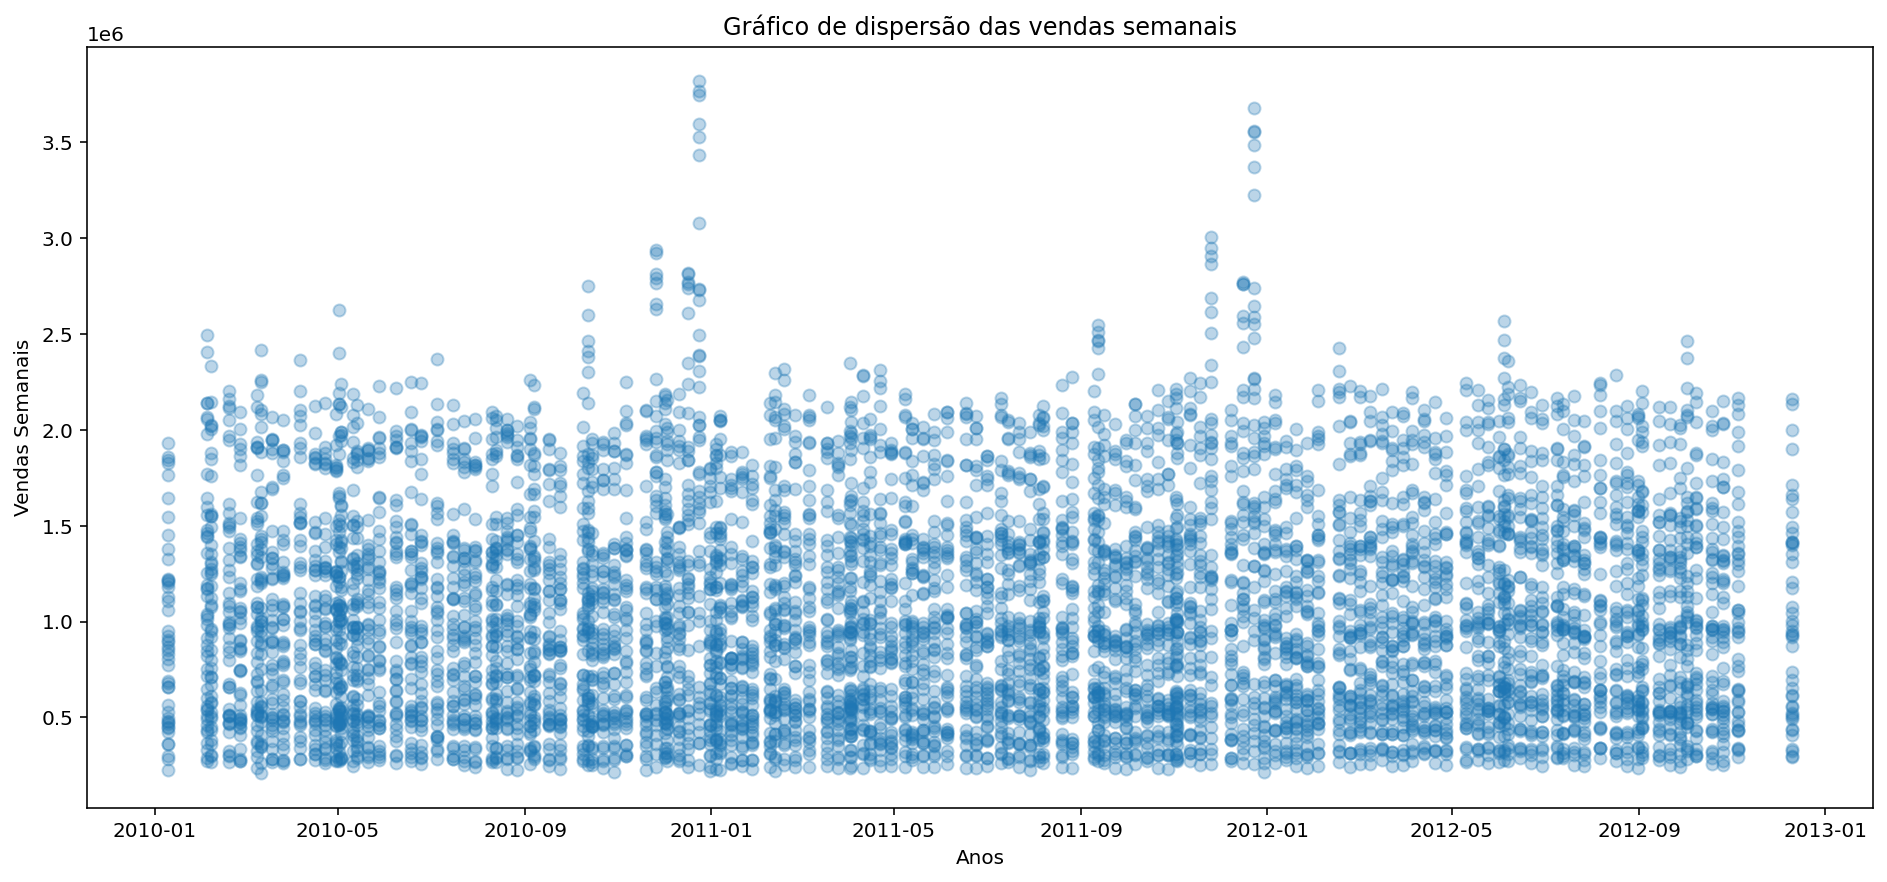

In [10]:
# Gráfico de dispersão das vendas semanais para todas as lojas ao longo do período 2010 a 2012

plt.figure(figsize=(16, 7))
plt.title('Gráfico de dispersão das vendas semanais')
plt.xlabel('Anos')
plt.ylabel('Vendas Semanais')
plt.plot(df.date, df.weeklysales, 'o', alpha=0.3)
plt.show()

* A partir do gráfico acima, percebe-se que nas semanas próximas ao fim de cada ano ocorre, em geral, um aumento nas vendas semanais

Store 26, year 2011


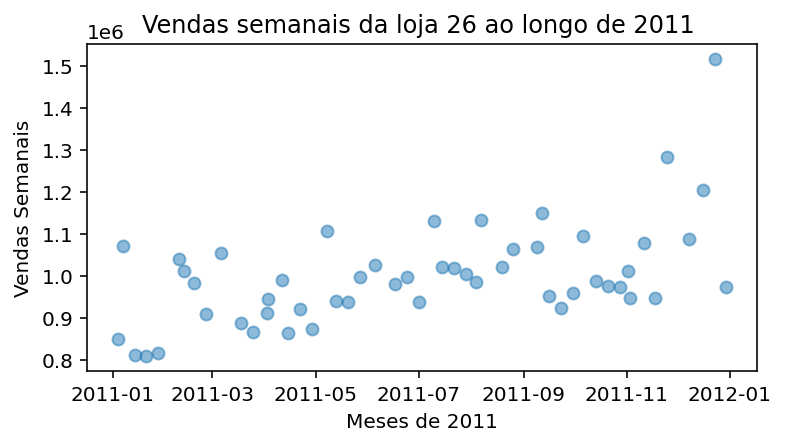

Store 18, year 2012


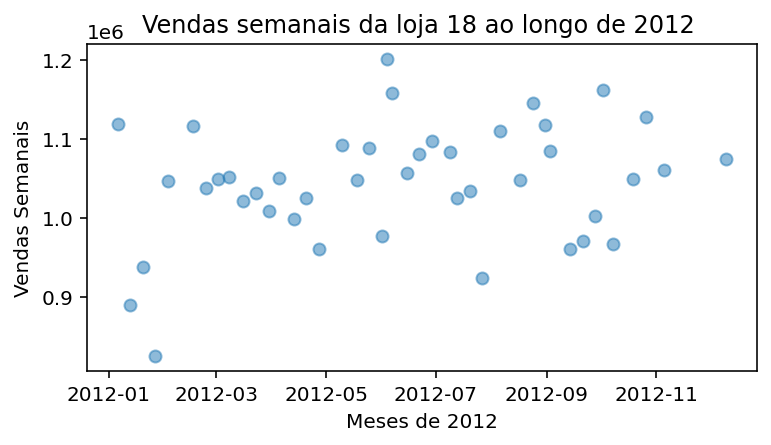

Store 44, year 2010


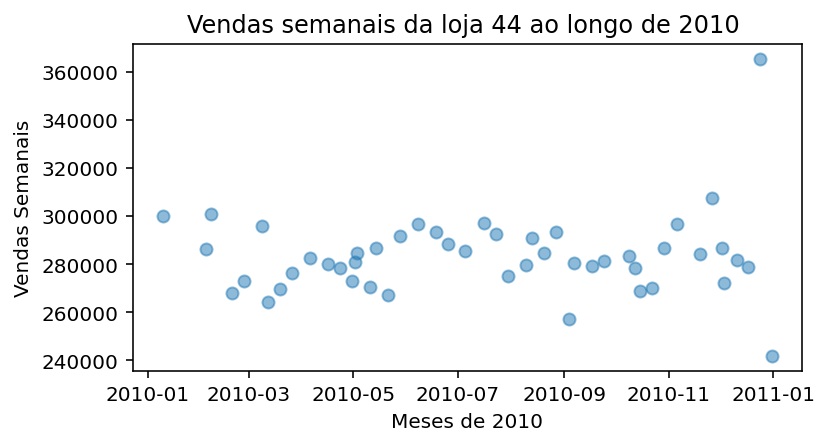

In [11]:
# Gráfico de dispersão das vendas semanais para lojas selecionadas aleatoriamente durante um ano selecionado também aleatoriamente

import random
teste_lojas = []
teste_anos = []
for x in range(3):
    
    a = True # loop para não repetir loja e ano
    while a == True:
        n = random.randint(1,45)
        year = random.randint(2010,2012)
        if n not in teste_lojas and year not in teste_anos:
            teste_lojas.append(n)
            teste_anos.append(year)
            a = False
    
    filtroano = []
    for i in df.date:
        if i.year == year:
            filtroano.append(True)
        else:
            filtroano.append(False)
    
    filtrostore = df.store == str(n)
    
    datesano = []
    for i in range(len(df)):
        if df.date[i].year == year and df.store[i] == str(n):
            datesano.append(df.date[i])
    
    salesyear = df.loc[filtroano & filtrostore,'weeklysales']
    
    print(f'Store {n}, year {year}')
    plt.figure(figsize=(6, 3))
    plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
    plt.ylabel('Vendas Semanais')
    plt.xlabel('Meses de {0}'.format(year))
    plt.plot(datesano, salesyear,'o', alpha=0.5)
    plt.show()

* Assim como observado no comportamento de todas as lojas juntas, percebe-se para cada loja que, em geral há um aumento nas vendas semanais no período próximo ao final do ano

In [12]:
# Análise da relação entre as variáveis weeklysales e holiday

no = df.holiday == "no"
yes = df.holiday == "yes"

holiday_no = df.loc[no,["weeklysales"]]
holiday_yes = df.loc[yes,["weeklysales"]]

medidas_resumo_holiday_no = holiday_no.describe()
medidas_resumo_holiday_yes = holiday_yes.describe()

In [13]:
# Análise das medidas resumo para semanas sem feriado

medidas_resumo_holiday_no.round(3)

,weeklysales
count,5985.000
mean,1041256.380
std,558957.436
min,209986.250
25%,551378.390
50%,956211.200
75%,1414343.530
max,3818686.450


In [14]:
# Análise das medidas resumo para semanas com feriado

medidas_resumo_holiday_yes.round(3)

,weeklysales
count,450.000
mean,1122887.892
std,627684.932
min,215359.210
25%,575865.482
50%,1018538.040
75%,1555213.175
max,3004702.330


* Analisando-se as medidas resumo obtidas acima, percebe-se que, quando há feriado, a média das vendas semanais é maior. No entanto, nessas mesmas semanas observa-se também uma variância maior, o que significa que há lojas com vendas bem maiores que outras e também que há feriados em que as vendas são maiores do que em outros.

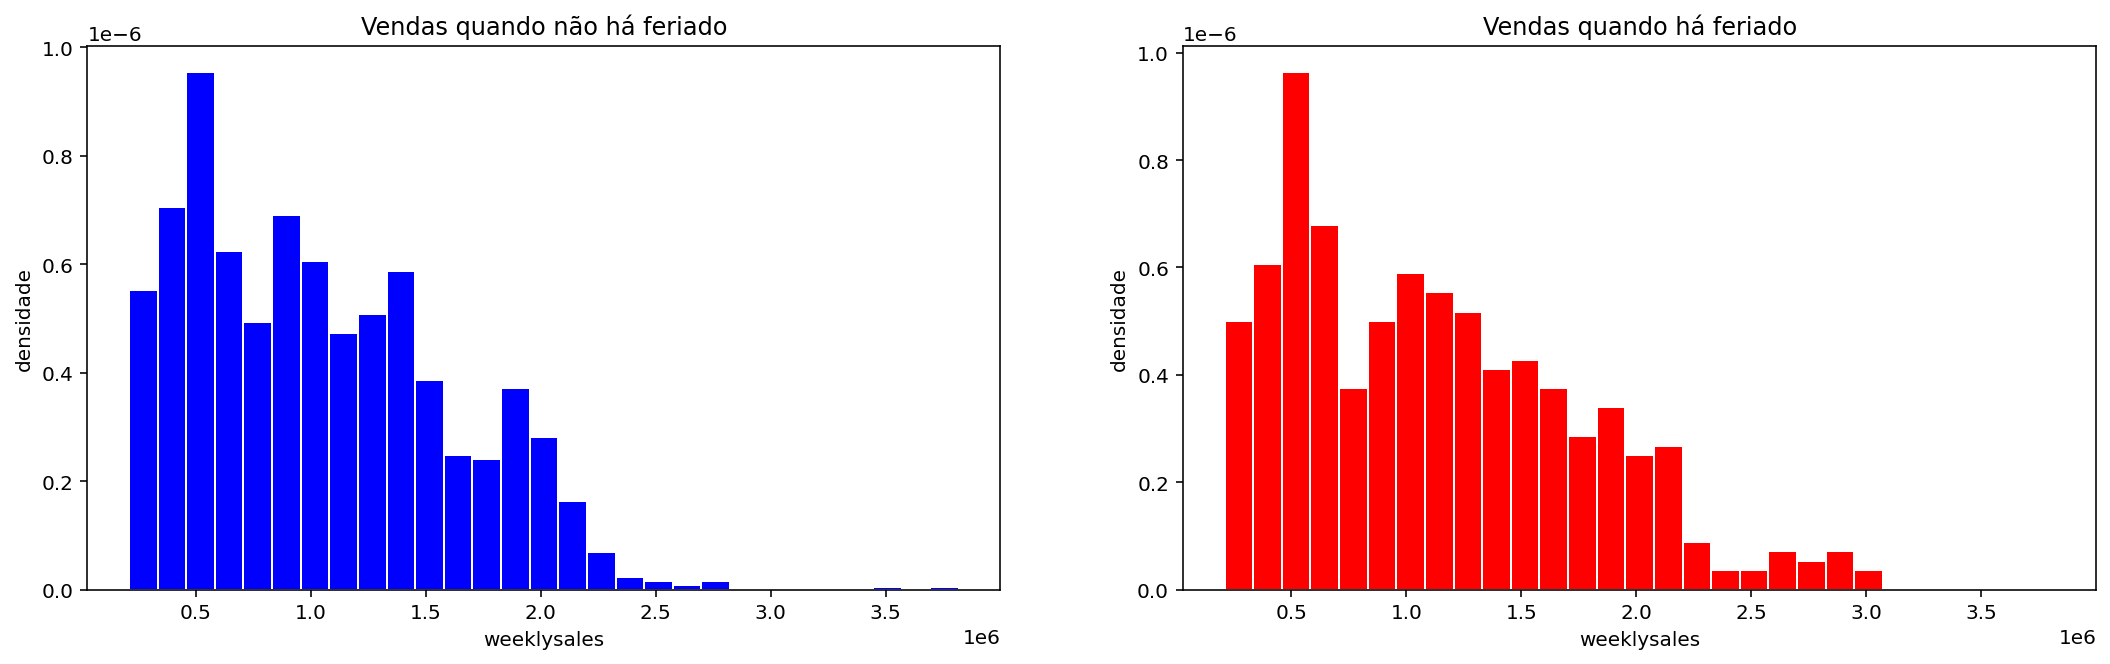

In [15]:
# Análise, em histograma, das vendas semanais para semanas em que não há ou não feriado

faixas = np.linspace(df.weeklysales.min(),df.weeklysales.max(),30)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(holiday_no.weeklysales, bins=faixas, density=True, color='blue', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando não há feriado')

plt.subplot(122)
plt.hist(holiday_yes.weeklysales, bins=faixas, density=True, color='red', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando há feriado')

plt.show()

In [16]:
# Criando faixas de temperatura correspondentes às estações - temperatura mínima a 40° F, 40° F a 55° F, 55° F a temperatura máxima

temp_minima = df.temperature.min()
temp_maxima = df.temperature.max()

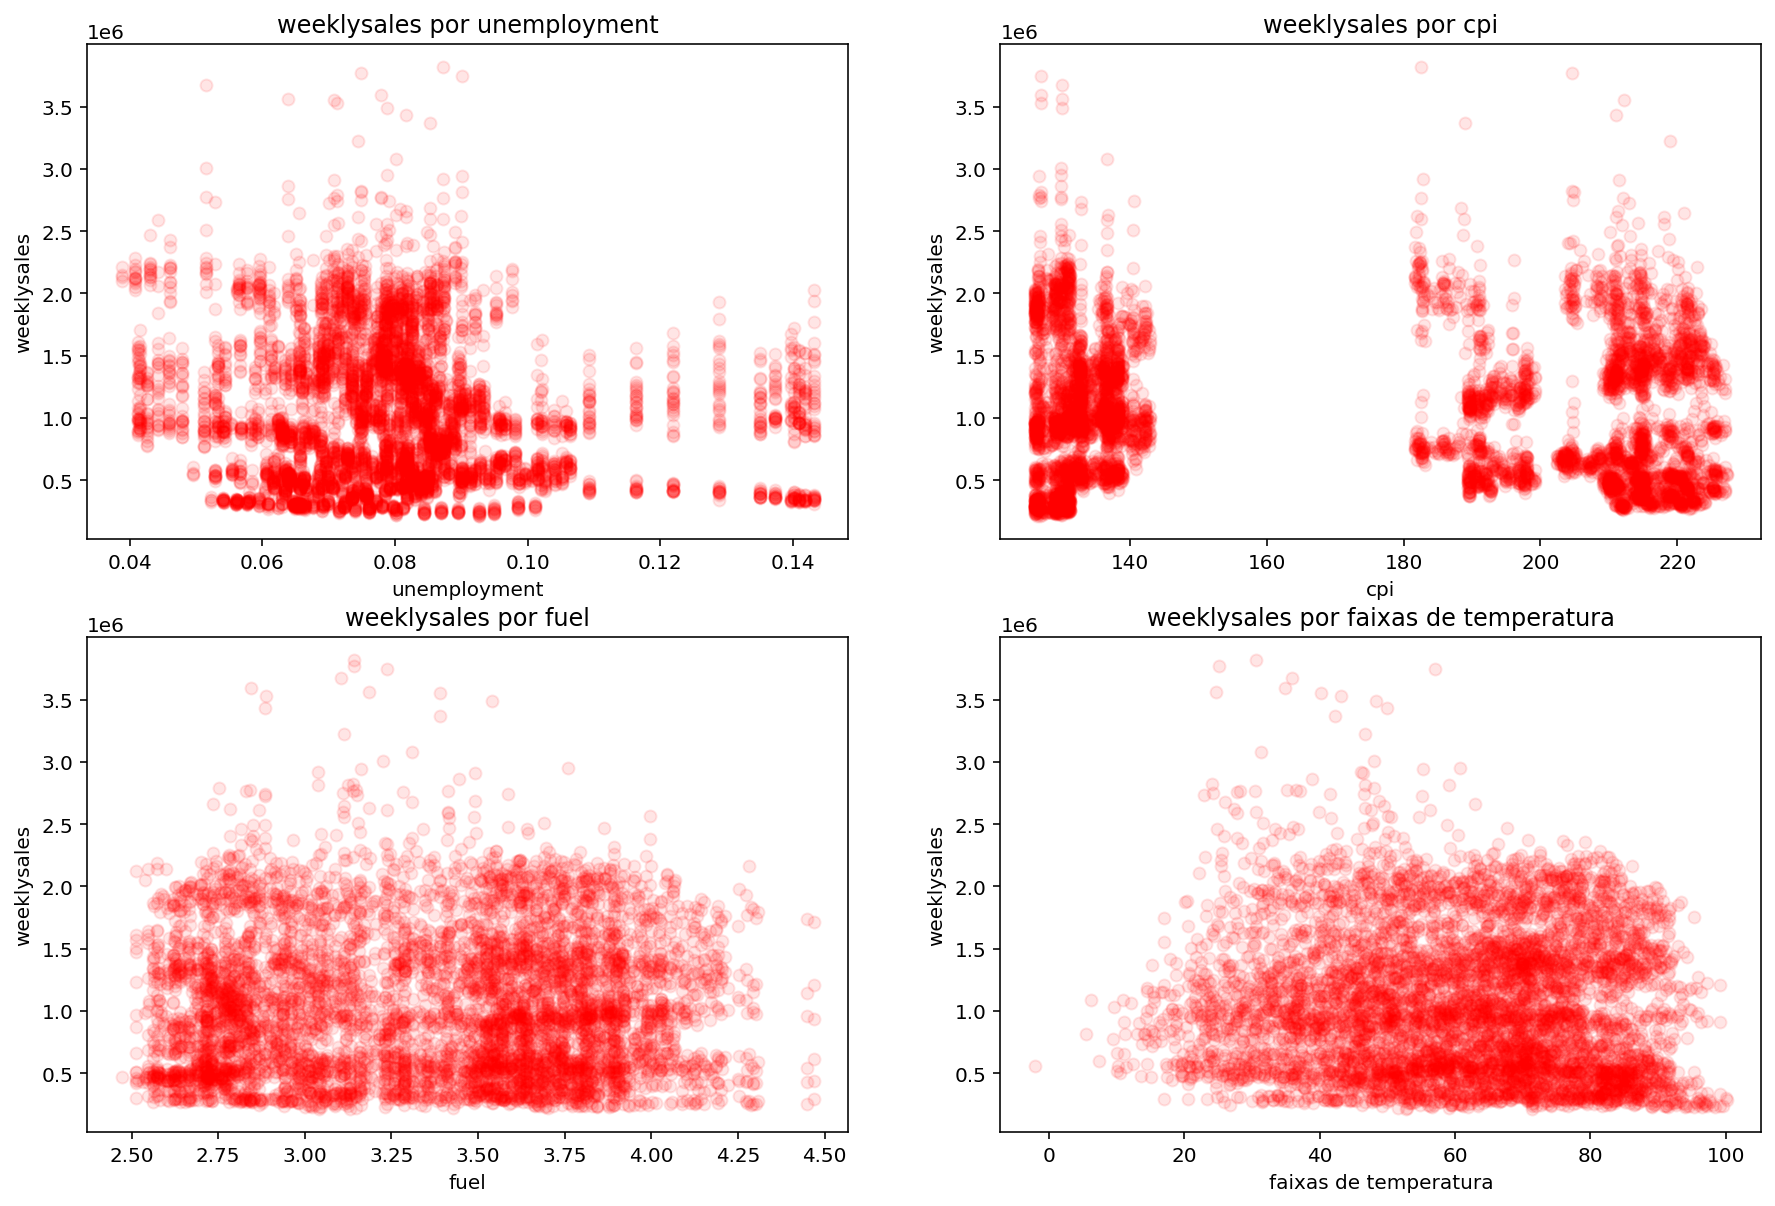

In [17]:
fig = plt.figure(figsize=(15,10))

# weeklysales com unemployment
plt.subplot(221)
plt.scatter(df.unemployment, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por unemployment')
plt.ylabel('weeklysales')
plt.xlabel('unemployment')

# weeklysales com cpi
plt.subplot(222)
plt.scatter(df.cpi, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por cpi')
plt.ylabel('weeklysales')
plt.xlabel('cpi')

# weeklysales com fuel
plt.subplot(223)
plt.scatter(df.fuel, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por fuel')
plt.ylabel('weeklysales')
plt.xlabel('fuel')

# weeklysales com temperature
plt.subplot(224)
plt.scatter(df.temperature, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por faixas de temperatura')
plt.ylabel('weeklysales')
plt.xlabel('faixas de temperatura')

plt.show()

In [18]:
# Correlações referentes às variáveis ilustradas nos gráficos acima

nomes = ['unemployment','cpi', 'fuel', 'temperature']
dfs = [df.unemployment, df.cpi, df.fuel, df.temperature]
for i in range(len(nomes)):
    print('Correlação entre {0} e weeklysales é: {1}'.format(nomes[i], df.weeklysales.corr(dfs[i])))

Correlação entre unemployment e weeklysales é: -0.10617608965795428
Correlação entre cpi e weeklysales é: -0.07263416204017631
Correlação entre fuel e weeklysales é: 0.009463786314475114
Correlação entre temperature e weeklysales é: -0.06381001317946956


* As correlações nos mostram uma baixa relação entre as features e o target. Sendo assim, teremos que fazer uma análise de múltiplas features

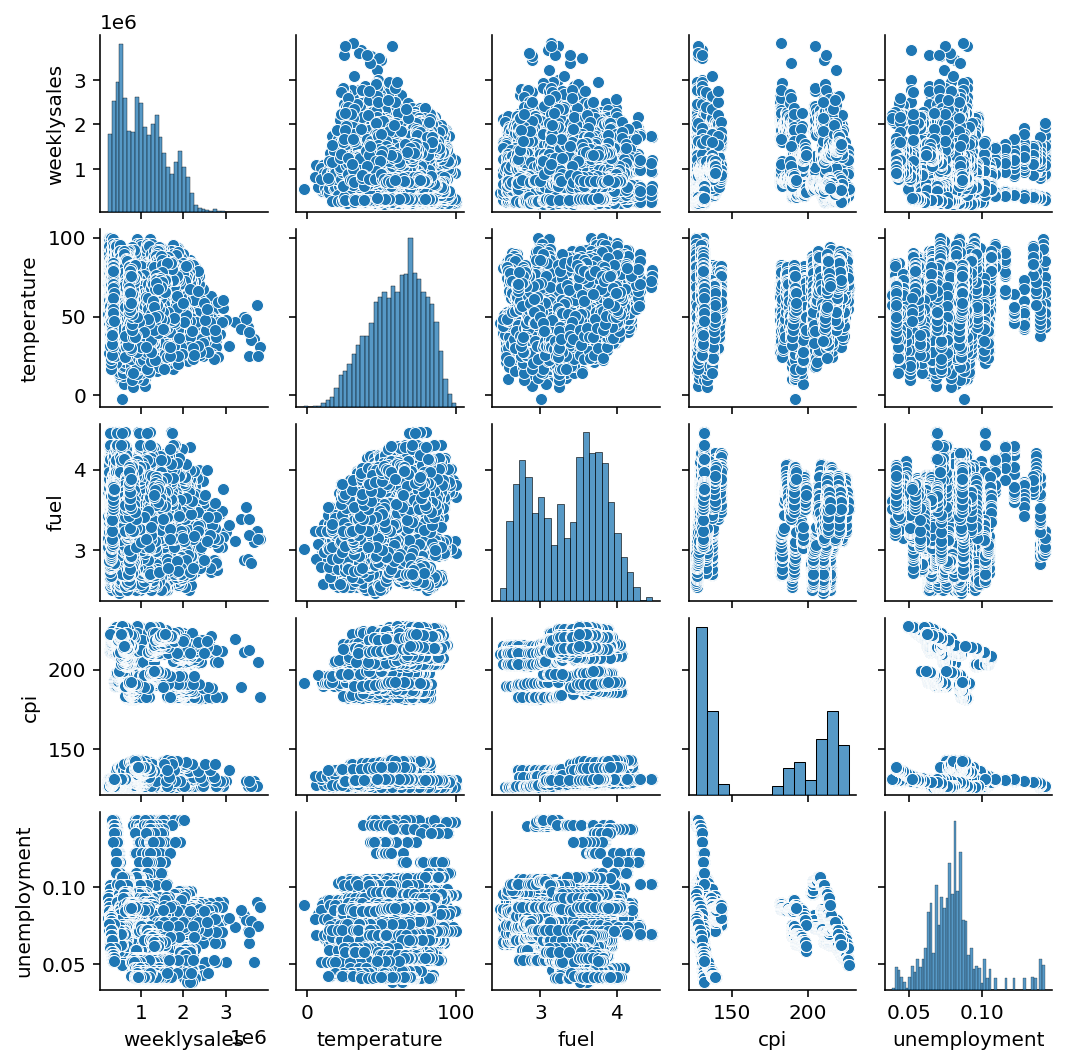

In [19]:
# Pairplot com as combinações de todas as variáveis quantitativas envolvidas

sns.pairplot(df, height=1.5);

## - Modelos de Predição -

In [20]:
# Separação da base de dados (Aproximadamente 75% para treinamento e 25% para teste)

# filtro_treinamento = []

# for i in range(len(df)):
#     if int(df.store[i]) == teste_lojas[0] and df.date.dt.year[i] == teste_anos[0]:
#         filtro_treinamento.append(False)
#     elif int(df.store[i]) == teste_lojas[1] and df.date.dt.year[i] == teste_anos[1]:
#         filtro_treinamento.append(False)
#     elif int(df.store[i]) == teste_lojas[2] and df.date.dt.year[i] == teste_anos[2]:
#         filtro_treinamento.append(False)
#     else:
#         filtro_treinamento.append(True)


# filtro_teste = []

# for i in range(len(df)):
#     if int(df.store[i]) == teste_lojas[0] and df.date.dt.year[i] == teste_anos[0]:
#         filtro_teste.append(True)
#     elif int(df.store[i]) == teste_lojas[1] and df.date.dt.year[i] == teste_anos[1]:
#         filtro_teste.append(True)
#     elif int(df.store[i]) == teste_lojas[2] and df.date.dt.year[i] == teste_anos[2]:
#         filtro_teste.append(True)
#     else:
#         filtro_teste.append(False)

# df_treinamento = df.loc[pd.Series(filtro_treinamento),:]
# df_teste = df.loc[pd.Series(filtro_teste),:]

In [21]:
# filtro_treinamento = df.date.dt.year != teste_anos[0]
# filtro_teste = df.date.dt.year == teste_anos[0]
# df_treinamento = df.loc[pd.Series(filtro_treinamento),:]
# df_teste = df.loc[pd.Series(filtro_teste),:]

In [22]:
'''
years = [2010, 2011, 2012]
dates = []
dates_treinamento = []
dates_teste = []
for year in years:
    for i in range(3):
        month = random.randint(1,12)
        a = str(year) + '-' + str(month)
        if a not in dates:
            dates.append(a)
    filtro = df.date.dt.year == year
    df_fatiado = df.loc[filtro,:]
    for i in range(len(df_fatiado)):
        print(i)
        if str(df_fatiado.date[i])[0:7] not in dates:
            print(str(df_fatiado.date[i])[0:7])
            dates_treinamento.append(df_fatiado.date[i])
        else:
            dates_teste.append(df_fatiado.date[i])

filtro_treinamento = df.date == dates_treinamento
filtro_teste = df.date == dates_teste
df_treinamento = df.loc[filtro_treinamento,:]
df_teste = df.loc[filtro_teste,:]
'''

"\nyears = [2010, 2011, 2012]\ndates = []\ndates_treinamento = []\ndates_teste = []\nfor year in years:\n    for i in range(3):\n        month = random.randint(1,12)\n        a = str(year) + '-' + str(month)\n        if a not in dates:\n            dates.append(a)\n    filtro = df.date.dt.year == year\n    df_fatiado = df.loc[filtro,:]\n    for i in range(len(df_fatiado)):\n        print(i)\n        if str(df_fatiado.date[i])[0:7] not in dates:\n            print(str(df_fatiado.date[i])[0:7])\n            dates_treinamento.append(df_fatiado.date[i])\n        else:\n            dates_teste.append(df_fatiado.date[i])\n\nfiltro_treinamento = df.date == dates_treinamento\nfiltro_teste = df.date == dates_teste\ndf_treinamento = df.loc[filtro_treinamento,:]\ndf_teste = df.loc[filtro_teste,:]\n"

In [37]:
x = df.date.dt.year
df['Year'] = pd.Series(x)
y = df.date.dt.month
df['Month'] = pd.Series(y)
df

df.Year = df.Year.astype('int')
df.Month = df.Month.astype('int')

In [38]:
df.dtypes

store                 category
date            datetime64[ns]
weeklysales            float64
holiday                  int64
temperature            float64
fuel                   float64
cpi                    float64
unemployment           float64
Ano                      int64
Mês                      int64
Year                     int64
Month                    int64
dtype: object

In [46]:
df_shuffle = df.sample(frac = 1) 
df_treinamento = df_shuffle.head(int(len(df)*(75/100)))
df_teste = df_shuffle.tail(int(len(df)*(25/100)))

In [44]:
df_treinamento

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,Ano,Mês,Year,Month
197,2,2011-02-18,2080884.82,2011,57.83,3.045,212.903312,0.08028,2011,2,2011,2
3602,26,2010-08-13,1011938.29,2010,61.58,2.810,132.630000,0.08445,2010,8,2010,8
1567,11,2012-09-21,1326132.98,2012,73.64,3.721,226.315150,0.06334,2012,9,2012,9
5921,42,2011-03-18,558239.32,2011,70.12,3.892,128.512193,0.08744,2011,3,2011,3
4744,34,2010-07-30,875976.83,2010,72.26,2.650,126.106903,0.09816,2010,7,2010,7
...,...,...,...,...,...,...,...,...,...,...,...,...
3764,27,2010-12-24,3078162.08,2010,31.34,3.309,136.597273,0.08021,2010,12,2010,12
5539,39,2012-10-02,1442988.44,2012,52.89,3.409,218.955100,0.07244,2012,10,2012,10
6311,45,2010-06-18,815130.50,2010,72.62,2.780,182.442420,0.08899,2010,6,2010,6
5522,39,2011-10-14,1384721.84,2011,73.79,3.274,216.088526,0.07716,2011,10,2011,10


In [47]:
df_teste

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,Ano,Mês,Year,Month
6192,44,2010-03-12,264214.12,2010,25.80,2.812,126.731333,0.07610,2010,3,2010,3
355,3,2011-03-06,394507.84,2011,84.29,3.699,218.644937,0.07574,2011,3,2011,3
4500,32,2011-05-20,1145084.76,2011,45.71,3.828,192.831317,0.08595,2011,5,2011,5
6364,45,2011-06-24,762861.78,2011,74.85,3.804,185.791961,0.08521,2011,6,2011,6
2234,16,2011-10-21,560104.16,2011,46.99,3.548,195.178999,0.06232,2011,10,2011,10
...,...,...,...,...,...,...,...,...,...,...,...,...
5673,40,2011-09-12,1158708.98,2011,34.48,3.470,136.503067,0.04420,2011,9,2011,9
1000,7,2012-10-26,495543.28,2012,42.53,3.686,199.219532,0.07557,2012,10,2012,10
5760,41,2010-12-11,1175326.23,2010,38.99,2.737,191.041147,0.07508,2010,12,2010,12
2305,17,2010-04-06,876902.87,2010,53.79,2.871,126.136065,0.06635,2010,4,2010,4


* 1° modelo a ser utilizado: Modelo de Regressão Linear Múltipla - adotando $α = 1%$

* Hipóteses:

**H0: não há relação entre weeklysales e a variável analisada - $β = 0$**

**H1: há relação entre weeklysales e a variável analisada - $β ≠ 0$**

In [48]:
# Regressão linear múltipla para a combinação weeklysales com temperature, fuel, cpi e unemployment - todas as variáveis quantitativas

x = df_treinamento[['temperature','fuel','cpi','unemployment', 'Year', 'Month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           2.78e-28
Time:                        21:35:43   Log-Likelihood:                -70709.
No. Observations:                4826   AIC:                         1.414e+05
Df Residuals:                    4819   BIC:                         1.415e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.475e+07   3.64e+07      2.600      0.009    2.33e+07    1.66e+08
temperature  -1072.7497    460.644     -2.329      0.020   -1975.822    -169.677
fuel          5.838e+04   3.14e+04      1.861      0.063   -3105.064     1.2e+05
cpi          -1155.8293    235.246     -4.913      0.000   -1617.019    -694.639
unemployment -4.405e+06   4.75e+05     -9.278      0.000   -5.34e+06   -3.47e+06
Year         -4.642e+04   1.82e+04     -2.556      0.011    -8.2e+04   -1.08e+04
Month          1.22e+04   2477.332      4.923      0.000    7339.337    1.71e+04
==============================================================================
Omnibus:                      242.321   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.804
Skew:                           0.562   Prob(JB):                     4.26e-59
Kurtosis:                       2.726   Cond. No.                     9.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de fuel é muito maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e fuel

In [49]:
# Regressão linear múltipla para a combinação weeklysales com temperature, cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'Year', 'Month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     28.23
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           2.66e-28
Time:                        21:37:58   Log-Likelihood:                -70711.
No. Observations:                4826   AIC:                         1.414e+05
Df Residuals:                    4820   BIC:                         1.415e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.972e+07   2.13e+07      1.864      0.062   -2.05e+06    8.15e+07
temperature   -908.1035    452.188     -2.008      0.045   -1794.598     -21.609
cpi          -1310.5685    220.126     -5.954      0.000   -1742.115    -879.022
unemployment -4.275e+06    4.7e+05     -9.102      0.000    -5.2e+06   -3.35e+06
Year         -1.896e+04   1.06e+04     -1.790      0.073   -3.97e+04    1800.339
Month         1.261e+04   2467.864      5.110      0.000    7773.861    1.75e+04
==============================================================================
Omnibus:                      242.312   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.695
Skew:                           0.564   Prob(JB):                     2.73e-59
Kurtosis:                       2.734   Cond. No.                     5.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de temperature é maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e temperature

In [50]:
# Regressão linear múltipla para a combinação weeklysales com cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'Month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     34.48
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           2.03e-28
Time:                        21:39:25   Log-Likelihood:                -70713.
No. Observations:                4826   AIC:                         1.414e+05
Df Residuals:                    4821   BIC:                         1.415e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.572e+06    6.3e+04     24.943      0.000    1.45e+06     1.7e+06
temperature   -996.1275    449.610     -2.216      0.027   -1877.568    -114.687
cpi          -1298.2528    220.068     -5.899      0.000   -1729.687    -866.818
unemployment -4.071e+06   4.56e+05     -8.932      0.000   -4.96e+06   -3.18e+06
Month         1.334e+04   2434.373      5.481      0.000    8570.961    1.81e+04
==============================================================================
Omnibus:                      244.173   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.239
Skew:                           0.569   Prob(JB):                     4.64e-60
Kurtosis:                       2.745   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
# RMS - erro no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMS_0 = np.sqrt(soma/len(df_treinamento))
RMS_0

558767.675811909

* Verificando as suposições do modelo de regressão linear 

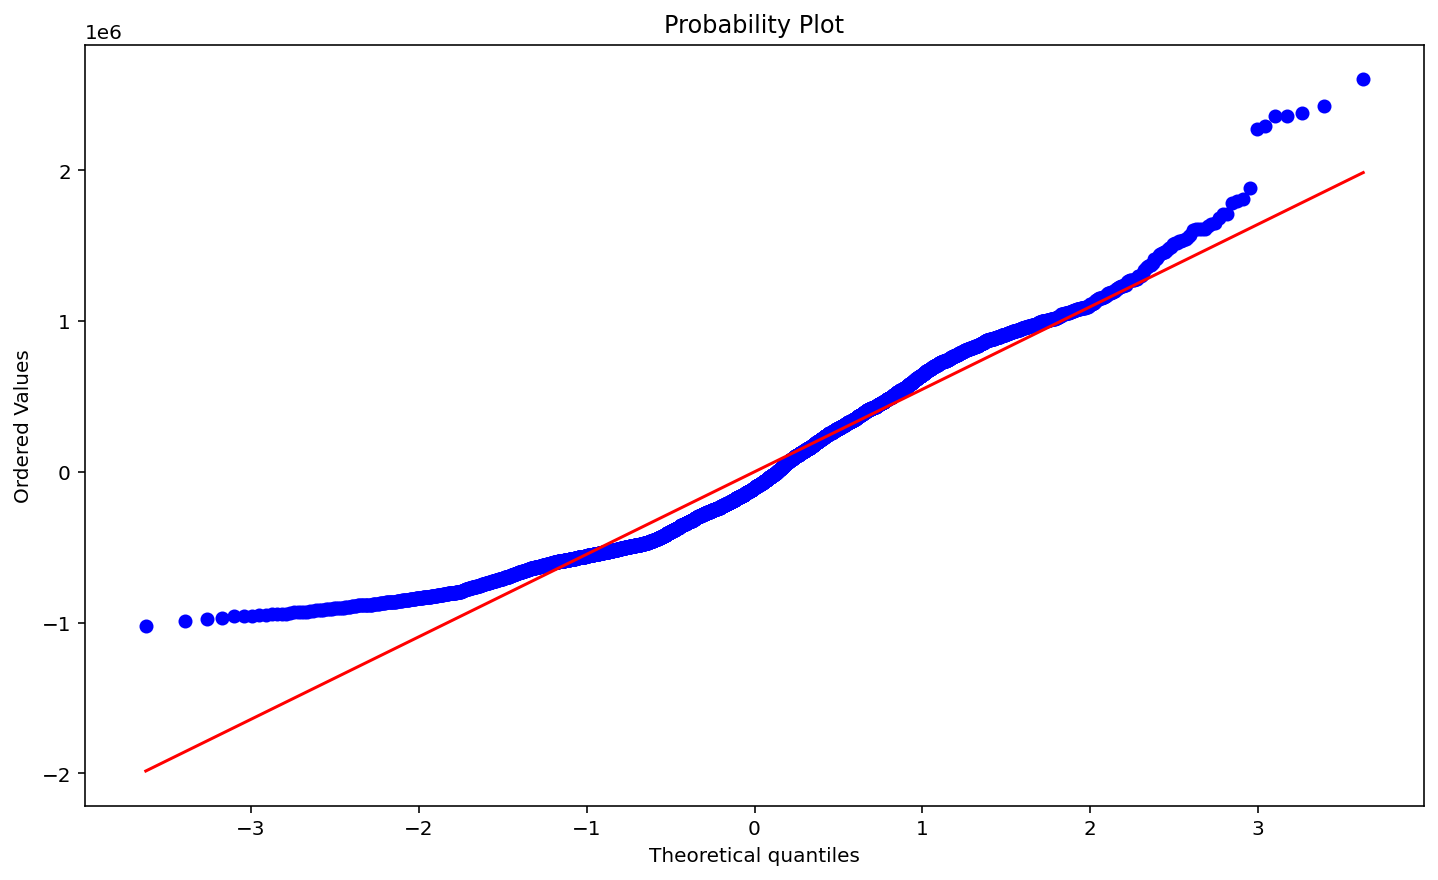

In [52]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(results.resid, dist='norm', plot=plt);

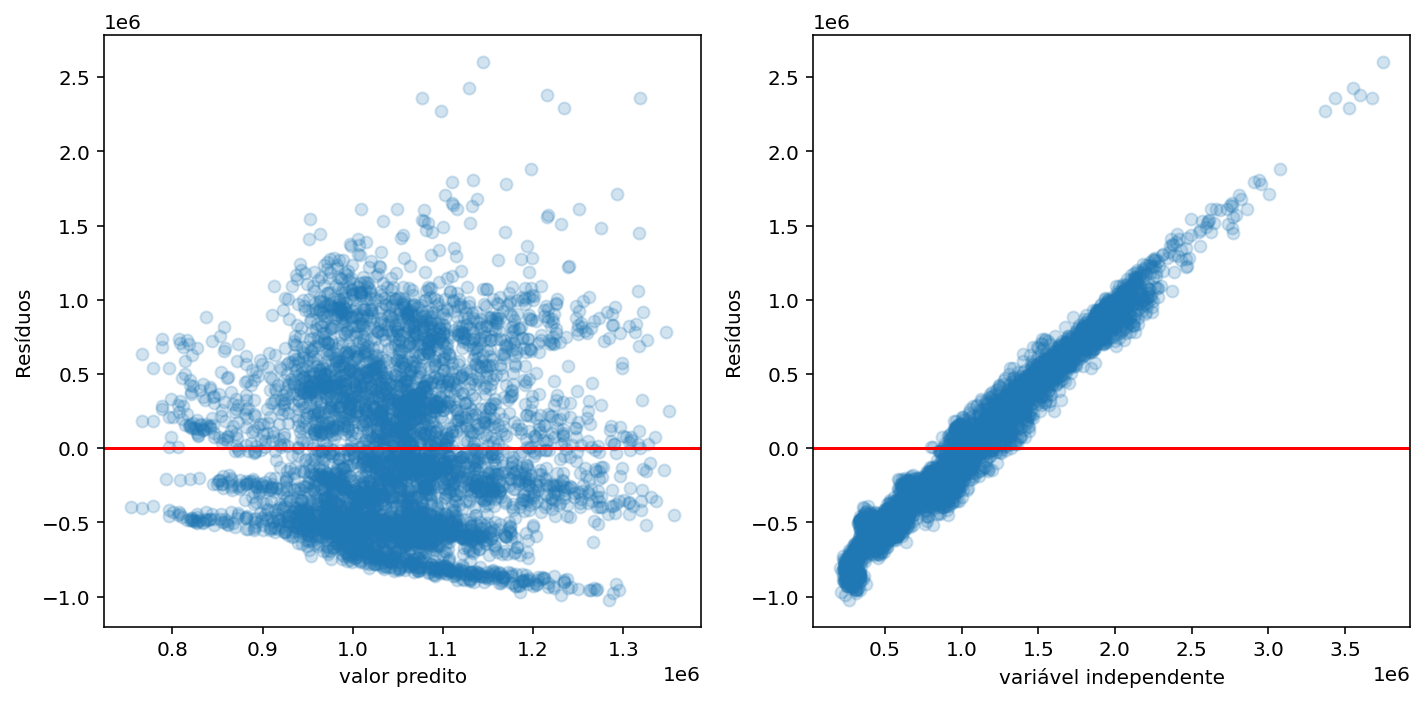

In [53]:
# Verificando a suposição de homocedasticidade:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(results.predict(xc), results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('valor predito')

plt.subplot(122)
plt.scatter(y, results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-'); # o valor da variável aleatórias está correto ?
plt.ylabel('Resíduos')
plt.xlabel('variável independente')

plt.tight_layout()
plt.show()

* Como evidenciado nos gráficos acima, as hipóteses do modelo não são seguidas. Dessa forma, afim de tentar ajustá-las, utilizou-se a escala logarítmica como ilustrado abaixo:

In [54]:
# Retira valores abaixo de 0

filtrotemperature1 = df_treinamento.temperature > 0
df_treinamento_log = df_treinamento.loc[filtrotemperature1,:]

filtrotemperature2 = df_teste.temperature > 0

df_teste_log = df_teste.loc[filtrotemperature2,:]

In [55]:
# Alterando a escala para log

df_treinamento_log.weeklysales = np.log(df_treinamento_log.weeklysales)
df_treinamento_log.temperature = np.log(df_treinamento_log.temperature)
df_treinamento_log.fuel = np.log(df_treinamento_log.fuel)
df_treinamento_log.cpi = np.log(df_treinamento_log.cpi)
df_treinamento_log.unemployment = np.log(df_treinamento_log.unemployment*100)
df_treinamento_log.Month = np.log(df_treinamento_log.Month)
df_treinamento_log.Year = np.log(df_treinamento_log.Year)
df_treinamento_log

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,Ano,Mês,Year,Month
4289,30,2012-10-26,12.993221,2012,4.255613,1.254476,5.407523,1.819699,2012,10,7.606885,2.302585
5703,40,2012-06-07,13.983481,2012,4.235265,1.263562,4.928916,1.424553,2012,6,7.606885,1.791759
3293,24,2010-05-03,14.160792,2010,3.603594,1.071241,4.880792,2.119383,2010,5,7.605890,1.609438
2186,16,2010-11-19,13.036009,2010,3.305420,1.014506,5.252437,1.943908,2010,11,7.605890,2.397895
143,2,2010-05-02,14.574909,2010,3.693618,0.944684,5.350685,2.119143,2010,5,7.605890,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...
4633,33,2011-11-03,12.509584,2011,4.197352,1.289233,4.855146,2.191765,2011,11,7.606387,2.397895
2895,21,2010-08-10,13.430700,2010,4.186012,0.968124,5.353773,2.099612,2010,8,7.605890,2.079442
342,3,2011-04-03,12.987882,2011,4.176078,1.190279,5.380688,2.021680,2011,4,7.606387,1.386294
5088,36,2011-09-09,12.774112,2011,4.355939,1.252477,5.368848,2.101325,2011,9,7.606387,2.197225


In [57]:
df_teste_log.weeklysales = np.log(df_teste_log.weeklysales)
df_teste_log.temperature = np.log(df_teste_log.temperature)
df_teste_log.fuel = np.log(df_teste_log.fuel)
df_teste_log.cpi = np.log(df_teste_log.cpi)
df_teste_log.unemployment = np.log(df_teste_log.unemployment*100)
df_teste_log.Month = np.log(df_teste_log.Month)
df_teste_log.Year = np.log(df_teste_log.Year)
df_teste_log

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,Ano,Mês,Year,Month
6192,44,2010-03-12,12.484515,2010,3.250374,1.033896,4.842069,2.029463,2010,3,7.605890,1.098612
355,3,2011-03-06,12.885394,2011,4.434263,1.308063,5.387449,2.024721,2011,3,7.606387,1.098612
4500,32,2011-05-20,13.950989,2011,3.822317,1.342342,5.261816,2.151181,2011,5,7.606387,1.609438
6364,45,2011-06-24,13.544832,2011,4.315486,1.336053,5.224628,2.142534,2011,6,7.606387,1.791759
2234,16,2011-10-21,13.235878,2011,3.849935,1.266384,5.273917,1.829697,2011,10,7.606387,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...
5673,40,2011-09-12,13.962817,2011,3.540379,1.244155,4.916347,1.486140,2011,9,7.606387,2.197225
1000,7,2012-10-26,13.113410,2012,3.750210,1.304542,5.294407,2.022474,2012,10,7.606885,2.302585
5760,41,2010-12-11,13.977056,2010,3.663305,1.006862,5.252489,2.015969,2010,12,7.605890,2.484907
2305,17,2010-04-06,13.684152,2010,3.985088,1.054660,4.837361,1.892359,2010,4,7.605890,1.386294


In [58]:
df_analise2 = df_treinamento_log[['weeklysales','temperature','fuel','cpi','unemployment', 'Year', 'Month']]
df_analise2.describe()

,weeklysales,temperature,fuel,cpi,unemployment,Year,Month
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000
mean,13.703181,4.047459,1.202576,5.120383,2.054307,7.606372,1.696692
std,0.592807,0.364420,0.139514,0.232485,0.224658,0.000396,0.682104
min,12.254797,1.711995,0.905028,4.836790,1.355577,7.605890,0.000000
25%,13.217954,3.853758,1.076452,4.880420,1.930797,7.605890,1.386294
50%,13.780178,4.139079,1.238954,5.216431,2.063312,7.606387,1.945910
75%,14.172442,4.317488,1.317480,5.359677,2.151181,7.606885,2.197225
max,15.137015,4.606569,1.496941,5.425975,2.661168,7.606885,2.484907


In [59]:
# Verificando se há valores indefinidos

df_analise2.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
Year            0
Month           0
dtype: int64

In [60]:
logx =  df_treinamento_log[['temperature','fuel','cpi','unemployment', 'Month', 'Year']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.78
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           2.91e-19
Time:                        21:44:21   Log-Likelihood:                -4273.9
No. Observations:                4826   AIC:                             8562.
Df Residuals:                    4819   BIC:                             8607.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          542.3218    299.812      1.809      0.071     -45.446    1130.090
temperature     -0.0974      0.025     -3.949      0.000      -0.146      -0.049
fuel             0.1864      0.111      1.685      0.092      -0.030       0.403
cpi             -0.1482      0.041     -3.620      0.000      -0.229      -0.068
unemployment    -0.2737      0.041     -6.619      0.000      -0.355      -0.193
Month            0.0572      0.013      4.427      0.000       0.032       0.083
Year           -69.3135     39.433     -1.758      0.079    -146.621       7.994
==============================================================================
Omnibus:                      492.033   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.388
Skew:                          -0.336   Prob(JB):                     2.29e-48
Kurtosis:                       2.200   Cond. No.                     3.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
logx =  df_treinamento_log[['temperature', 'cpi','unemployment', 'Month']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     24.35
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           5.63e-20
Time:                        21:45:16   Log-Likelihood:                -4275.6
No. Observations:                4826   AIC:                             8561.
Df Residuals:                    4821   BIC:                             8594.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.3788      0.232     66.237      0.000      14.924      15.834
temperature     -0.0924      0.024     -3.831      0.000      -0.140      -0.045
cpi             -0.1722      0.038     -4.502      0.000      -0.247      -0.097
unemployment    -0.2553      0.039     -6.497      0.000      -0.332      -0.178
Month            0.0615      0.013      4.872      0.000       0.037       0.086
==============================================================================
Omnibus:                      484.311   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.015
Skew:                          -0.334   Prob(JB):                     7.51e-48
Kurtosis:                       2.204   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
# beta0_1 = logresults.params[0]
# beta1_1 = logresults.params[1]
# beta2_1 = logresults.params[2]
# beta3_1 = logresults.params[3]

# def f1(feature1, feature2, feature3):
#     return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3

# npoints = 100
# feature1 = df_treinamento_log.temperature
# feature2 = df_treinamento_log.cpi
# feature3 = df_treinamento_log.unemployment
# x_vc = np.linspace(feature1.min(), feature1.max(), npoints)
# y_vc = np.linspace(feature2.min(), feature2.max(), npoints)
# z_vc = np.linspace(feature3.min(), feature3.max(), npoints)

# eixo_x, eixo_y, eixo_z = np.meshgrid(x_vc, y_vc, z_vc)

# f_log = f1(eixo_x, eixo_y, eixo_z)

In [62]:
# RMS log - erro
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMS_1 = np.sqrt(soma/len(df_treinamento_log))
RMS_1

0.5868474146850747

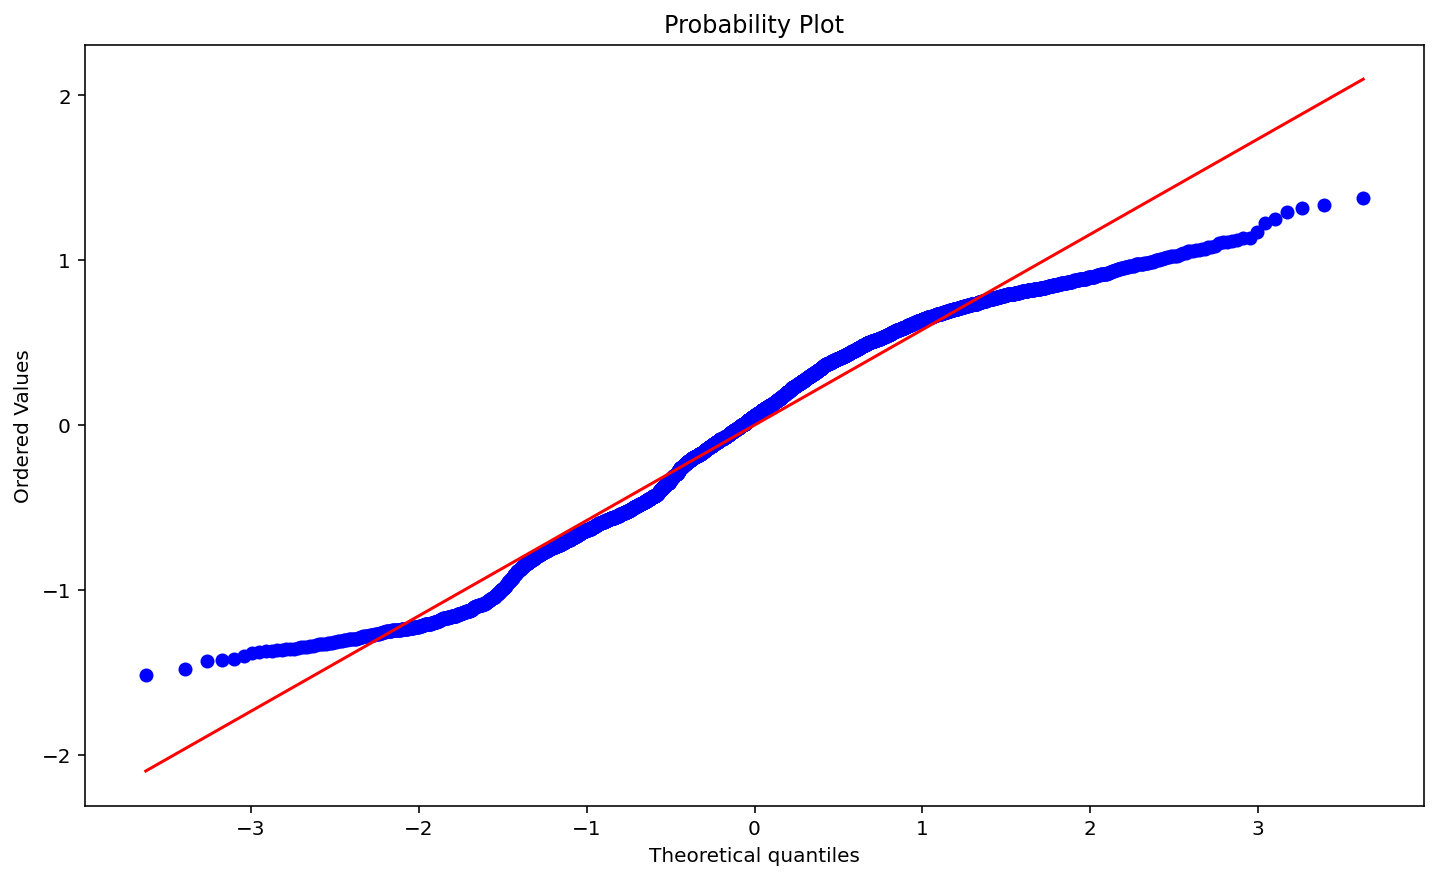

In [63]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(logresults.resid, dist='norm', plot=plt);

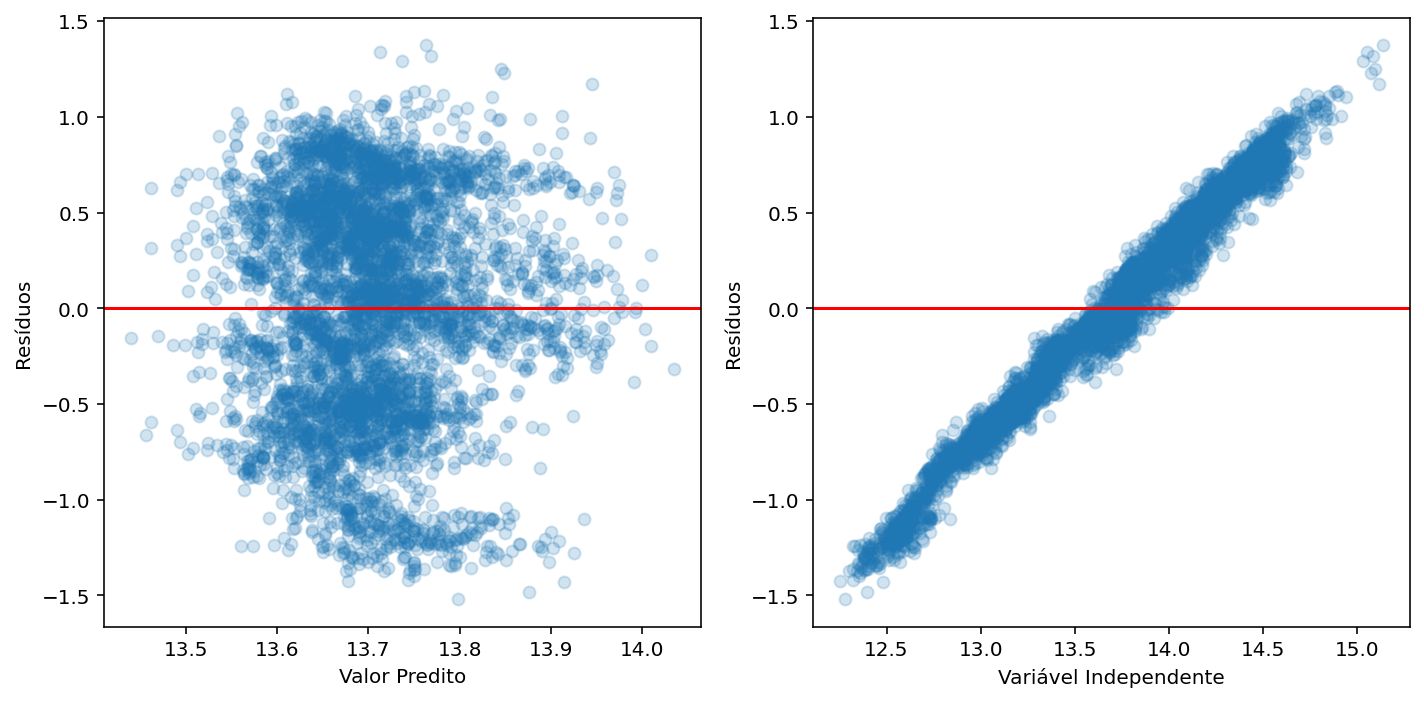

In [64]:
# Verificando a suposição de homocedasticidade na escala log:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(logresults.predict(logxc), logresults.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(logy, logresults.resid, alpha=0.2); # o valor da variável aleatórias está correto ?
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* 2° Modelo a ser utilizado: 

In [0]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

* Médias móveis - k vizinhos mais próximos

In [0]:
'''n = random.randint(1,45)
year = random.randint(2010,2012)
month = random.randint(1,12)

filtroano = []
for i in df.date:
    if i.year == year:
        filtroano.append(True)
    else:
        filtroano.append(False)

filtrostore = df.store == str(n)

datesano = []
for i in range(len(df)):
    if df.date[i].year == year and df.store[i] == str(n):
        datesano.append(df.date[i])

salesyear = df.loc[filtroano & filtrostore,'weeklysales']

print(f'Store {n}, year {year}')
plt.figure(figsize=(6, 3))
plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
plt.ylabel('Vendas Semanais')
plt.xlabel('Meses de {0}'.format(year))
plt.plot(datesano, salesyear,'o', alpha=0.5)
plt.show()
'''

In [0]:
'''
# Define uma variavel chamada Y que é a copia da serie de dados:
Y = df_treinamento.weeklysales

# Define a variável window = 2 que será a janela de 2 valores:
window = 2

# Obtém os 2 primeiros valores da serie:
history = []
for i in range(window):
    history.append(Y.iloc[i])

# Obtém todos os valores após os 2 primeiros:
test = []
for i in range(window, len(Y)):
    test.append(Y.iloc[i])

# Cria lista de predições:
predicoes = []

# percorre sobre os dados de treinamento...

for t in range(len(test)):
    # Define a variável length com o tamanho da variável history:

    length = len(history)
    
    # Define a variável valor_predito com a média dos 2 valores correntes..
    valor_predito = []
    for i in range(length - window, length):
        valor_predito.append(history[i])
    valor_predito = np.mean(valor_predito)
    
    # Define a variável valor_real com o valor atual do teste..
    valor_real = test[t]
    
    # Alimenta a lista de predições:
    predicoes.append(valor_predito)
    # Atualiza a lista history com os valores correntes..
    history.append(valor_real)
    '''

In [0]:
'''from sklearn.metrics import mean_squared_error'''

In [0]:
'''
# Calcula a métrica de rms:
rms = np.sqrt(mean_squared_error(test, predicoes)) 
# Imprime o valor de rms:
print('Métrica RMS: %.3f' % rms)
'''

In [0]:
'''
# Habilita o modo offline:
import plotly
import plotly.offline as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
# Habilita o renderizador do colab:
import plotly.io as pio
pio.renderers
pio.renderers.default = "colab"
'''

In [0]:
'''# Escolhendo, de forma aleatória, uma loja com dados pertencentes à base de treinamento para verificar as médias



# Plotando o gráfico para a loja selecionada
indices = [i for i in range(0, int(len(test)))]

teste = go.Scatter(x=indices,y=test,name = "Conjunto de treinamento",line = dict(color = '#330000'),opacity = 0.8)

MM_2 = go.Scatter(x=indices,y=predicoes,name = "Média Móvel 2 Períodos",line = dict(color = '#FF00FF'),opacity = 0.8)

data = [teste, MM_2]

layout = dict(title = "Treinamento set vs Média Móvel 2 períodos",title_x= 0.5)

fig = dict(data=data, layout=layout)

py.iplot(fig)'''

In [0]:
'''# gráfico para arrumar modelo 2
print(f'Store {n}, year {year}')
plt.figure(figsize=(6, 3))
plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
plt.ylabel('Vendas Semanais')
plt.xlabel('Meses de {0}'.format(year))
plt.plot(dates_treinamento, dados_treinamento.weeklysales,'o', alpha=0.5)
plt.show()'''

In [0]:
'''x = df_treinamento[['temperature','fuel','cpi','unemployment']]

xc = sm.add_constant(x)
model = sm.OLS(Y,xc)
results = model.fit()
results.summary()'''

### Fazendo um modelo de random Forest ! 

In [83]:
from sklearn.model_selection import train_test_split

columns = df.columns.drop(['weeklysales', 'Year', 'Month', 'date'])
columns

Index(['store', 'holiday', 'temperature', 'fuel', 'cpi', 'unemployment', 'Ano',
       'Mês'],
      dtype='object')

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['weeklysales'], test_size=0.25)

In [85]:
tree_rf = RandomForestRegressor()

In [86]:
model_rf = tree_rf.fit(X_train, y_train)

resultado_rf = model_rf.predict(X_test)

In [87]:
mean_squared_error(y_test, resultado_rf)

20081918218.15441

In [88]:
model_rf.score(X_test,y_test)

0.9356861150091629

In [92]:
from sklearn.model_selection import GridSearchCV # GridSearchCV faz teste exaustivamente encontrando os melhores parâmetros 

In [93]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]} # vamos especificar os parâmetros que eu quero ajustar para melhorar

# valores mínimosde amostras para serem testadas na folha da árvore // valores mínimos de amostras para fazer a divisão do módulo interno, ajuda em deixar o modelo mais fluido. // árvores de decisão

In [94]:
rf = RandomForestRegressor() #qual regressão vou usar 
grid = GridSearchCV(rf, parametros)

In [95]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'min_samples_leaf': [1, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 250, 500, 750]})

In [96]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 750}

In [97]:
rf_best = grid.best_estimator_
resultado_final = rf_best.predict(X_test)

In [98]:
mean_squared_error(y_test, resultado_final)

18813197109.60146

In [99]:
rf_best.score(X_test,y_test)

0.9397492917721852

In [0]:
rf_best.predict(X_test)
X_test

array([ 287023.38494368, 1321530.33251008,  686933.09930301, ...,
        437259.51140867,  321244.01567216, 1453873.55268282])

## - Processo e Estatísticas de Validação -

##### Validação do modelo 1

In [71]:
beta0_1 = logresults.params[0]
beta1_1 = logresults.params[1]
beta2_1 = logresults.params[2]
beta3_1 = logresults.params[3]
beta4_1 = logresults.params[4]

def f_modelo1(feature1, feature2, feature3, feature4): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3 + beta4_1*feature4

teste_1 = df_teste_log.weeklysales
predicoes_1 = f_modelo1(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.Month)
residuos_1 = teste_1 - predicoes_1 #lista de residuos
soma = 0
for resid in residuos_1:
    soma += resid**2
RMS_modelo1 = np.sqrt(soma/len(df_teste_log))
RMS_modelo1

0.5683107067151855

In [72]:
def r_squared(dados, modelo):
    numerador = 0
    denominador = 0
    for i in range(len(modelo)):
        numerador += (dados[i]-modelo[i])**2
        denominador += (dados[i]-np.mean(dados))**2
    return 1 - numerador/denominador

In [73]:
r_sqr_1 = r_squared(list(teste_1),list(predicoes_1))
r_sqr_1

0.021929417597423617

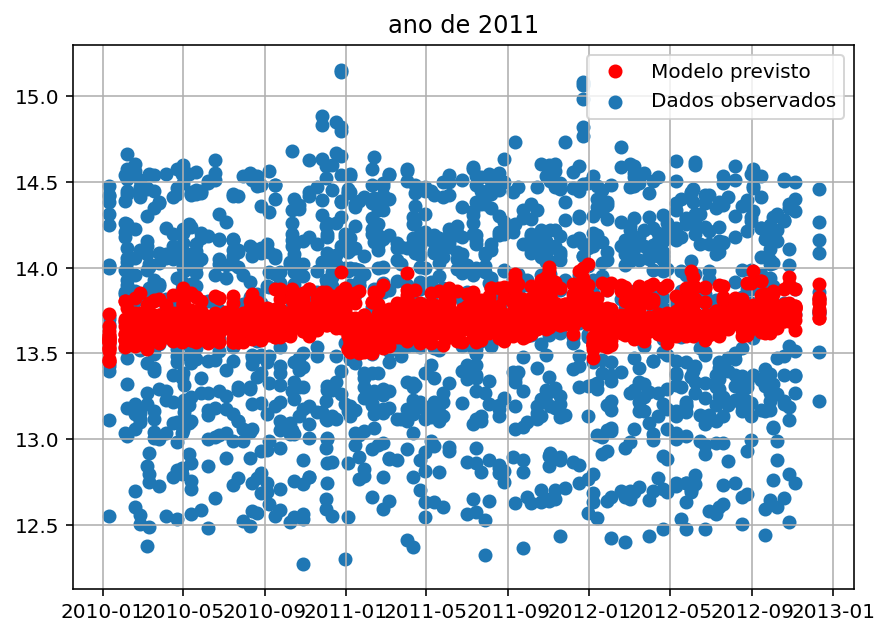

In [76]:
y_teste = df_teste_log.weeklysales
y_previsto = f_modelo1(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.Month)
x = df_teste_log.date

plt.figure(figsize=(7,5))
plt.title('ano de {0}'.format(teste_anos[0]))
plt.plot(x, y_previsto, 'ro', label='Modelo previsto')
plt.scatter(x, y_teste, label='Dados observados')
plt.legend()
plt.grid(True)
plt.show()

##### Validação do modelo Random Forest

In [0]:
plt.plot(X_test.Anos)

#### Rascunhos

In [0]:
# Validação do modelo 2 - gráfico com dados dos meses da base de teste previstos pelo modelo comparados com os dados esperados (os da base de teste)


In [0]:
# Define uma variavel chamada Y que é a copia da serie de dados:
Y = df_teste.weeklysales

# Define a variável window = 2 que será a janela de 2 valores:
window = 2

# Obtém os 5 primeiros valores da serie:
history = []
for i in range(window):
    history.append(Y.iloc[i])

# Obtém todos os valores após os 2 primeiros:
teste_2 = []
for i in range(window, len(Y)):
    teste_2.append(Y.iloc[i])

# Cria lista de predições:
predicoes_2 = []

# percorre sobre os dados de treinamento...

for t in range(len(teste_2)):
    # Define a variável length com o tamanho da variável history:
    length = len(history)
    
    # Define a variável valor_predito com a média dos 3 valores correntes..
    valor_predito = []
    for i in range(length - window, length):
        valor_predito.append(history[i])
    valor_predito = np.mean(valor_predito)
    
    # Define a variável valor_real com o valor atual do teste..
    valor_real = teste_2[t]
    
    # Alimenta a lista de predições:
    predicoes_2.append(valor_predito)
    # Atualiza a lista history com os valores correntes..
    history.append(valor_real)
    

# Calcula a métrica de rms:
rms = np.sqrt(mean_squared_error(teste_2, predicoes_2))
# Imprime o valor de rms:
print('Métrica RMS: %.3f' % rms)

indices = [i for i in range(0, int(len(teste_2)))]
teste = go.Scatter(x=indices,y=teste_2,name = "Conjunto de teste",line = dict(color = '#330000'),opacity = 0.8)
MM_2 = go.Scatter(x=indices,y=predicoes_2,name = "Média Móvel 2 Períodos",line = dict(color = '#FF00FF'),opacity = 0.8)
data = [teste, MM_2]
layout = dict(title = "Teste set vs Média Móvel 2 períodos",title_x= 0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [0]:
# RMS modelo 2 - validação:



In [0]:
r_sqr_2 = r_squared(teste_2,predicoes_2)
r_sqr_2

In [0]:
# Comparação e discussão dos resultados

## - Conclusão -

## - Referências Bibliográficas -

* https://d1wqtxts1xzle7.cloudfront.net/41933645/FORECAST_OF_SALES_OF_WALMART_STORE_USING_BIG_DATA_APPLICATIONS.pdf?1454491981=&response-content-disposition=inline%3B+filename%3DFORECAST_OF_SALES_OF_WALMART_STORE_USING.pdf&Expires=1605614440&Signature=DPer3zvFl7B5EM46LJWPgYXscJNdxbzVCfa308NyoF6sU9ydieGyJ0wbXUYIkQ5l9GWfB8d1GciSQtJPGLAwgjCWJ2f5267cw~gdIlOPukMk~TeRzlDOdRlIZJ~v2u6kUL0J0AlpLZZEgLIsFtJMwgeSrdCPuXGjIH67jWaTNEJxLuPRc70jIoita-hdS7n2HF1uSmHok7tUWeJVvAhMxqT~vZ-XKuJMb8OTGCkyhwVazQJ7RpwR406ffqcOST4aDrioWlof4iW~hXYQbtWBoHg-l4pSll8jD7EnhkHm3jxqz-L2soAs4KeCxC7Vjzk6PPvnH4nmtRxKqM~imc8auw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

* https://www.lume.ufrgs.br/bitstream/handle/10183/147496/000999425.pdf?sequence=1

* http://prcrepository.org:8080/xmlui/bitstream/handle/20.500.12475/174/FA-19_Articulo%20Final_Jose%20Santaella.pdf?sequence=1

* https://www.cse.scu.edu/~mwang2/projects/ML_KaggleM5Forecasting_20s.pdf

* https://medium.com/datadriveninvestor/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

* https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

* https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/

* https://minerandodados.com.br/prevendo-dados-com-janelas-deslizantes-usando-python/

* https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

* https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

* https://minerandodados.com.br/prevendo-a-demanda-de-alugueis-de-bicicletas-com-machine-learning/

* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Commit:
    
Membros: Andressa, Camila, Luiz, Matheus

In [0]:
'''
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
# data sample
df_analise2 = df_treinamento_log[['weeklysales','temperature','cpi','unemployment']]
logx = df_analise2.iloc[:, [1,3]]
scaler = MinMaxScaler(feature_range=(0, 1))
logx = scaler.fit_transform(logx)
logy = df_analise2.iloc[:,0]
data = array(df_analise2)
# prepare cross validation
kfold = KFold(3, True, 1)
# enumerate splits
scores = []
best_svr = SVR(kernel='rbf')
for train, test in kfold.split(data):
    print('train: %s, test: %s' % (data[train], data[test]))
    X_train, X_test, y_train, y_test = logx[train], logx[test], logy[train], logy[test]
    #best_svr.fit(X_train, y_train)
    #scores.append(best_svr.score(X_test, y_test))
    #print(scores)
    '''